In [1]:
import numpy as np
import random

import os
import pickle
import sys
import timeit

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_spd_matrix
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter

from matplotlib.pyplot import imshow
%matplotlib inline 

from IPython.display import Image 

import pickle

<img src="split_treatment.png" width="400"/>

p_A: 0.5208, IPTW: 1.00 +/- 0.09
Unbiased estimated CATE: 1.24, 1.29, 1.32, 1.36
Unbiased recovered CATE: 1.17, 1.96, 3.04, 3.84.
52.5% A matched Z, RMSE: 0.96
p_A: 0.4736, IPTW: 1.00 +/- 0.08
Unbiased estimated CATE: 1.15, 1.38, 1.54, 1.78
Unbiased recovered CATE: 1.51, 2.23, 2.79, 3.49.
57.4% A matched Z, RMSE: 0.97
p_A: 0.4235, IPTW: 1.00 +/- 0.09
Unbiased estimated CATE: 1.34, 1.56, 1.76, 1.98
Unbiased recovered CATE: 1.18, 1.96, 3.03, 3.82.
63.6% A matched Z, RMSE: 0.76
p_A: 0.3736, IPTW: 1.00 +/- 0.09
Unbiased estimated CATE: 1.40, 1.69, 1.96, 2.24
Unbiased recovered CATE: 1.18, 1.96, 3.03, 3.82.
67.7% A matched Z, RMSE: 0.69
p_A: 0.3284, IPTW: 1.00 +/- 0.08
Unbiased estimated CATE: 1.45, 1.91, 2.34, 2.81
Unbiased recovered CATE: 1.30, 2.07, 2.95, 3.68.
72.5% A matched Z, RMSE: 0.54
p_A: 0.5747, IPTW: 1.00 +/- 0.09
Unbiased estimated CATE: 1.13, 1.31, 1.49, 1.68
Unbiased recovered CATE: 1.15, 1.94, 3.05, 3.86.
58.2% A matched Z, RMSE: 0.80
p_A: 0.525, IPTW: 1.00 +/- 0.08
Unbiased

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


p_A: 0.6709, IPTW: 1.00 +/- 0.09
Unbiased estimated CATE: 0.83, 1.58, 2.03, 2.77
Unbiased recovered CATE: 1.56, 2.27, 2.77, 3.45.
78.0% A matched Z, RMSE: 0.52


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


p_A: 0.6137, IPTW: 1.00 +/- 0.09
Unbiased estimated CATE: 0.86, 1.62, 2.28, 3.02
Unbiased recovered CATE: 1.33, 2.09, 2.93, 3.66.
83.2% A matched Z, RMSE: 0.47


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


p_A: 0.5682, IPTW: 1.00 +/- 0.07
Unbiased estimated CATE: 1.21, 1.87, 2.24, 2.90
Unbiased recovered CATE: 1.56, 2.26, 2.72, 3.40.
87.2% A matched Z, RMSE: 0.56


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


p_A: 0.535, IPTW: 1.00 +/- 0.08
Unbiased estimated CATE: 1.16, 1.93, 2.60, 3.37
Unbiased recovered CATE: 1.35, 2.10, 2.91, 3.65.
92.7% A matched Z, RMSE: 0.45


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


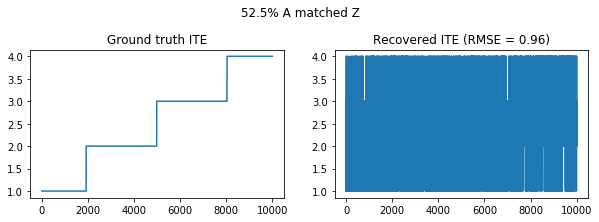

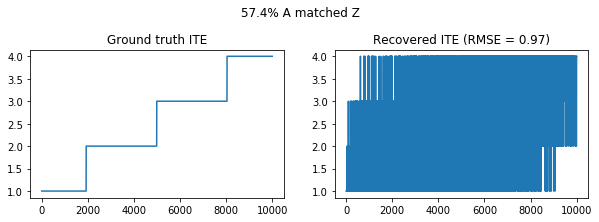

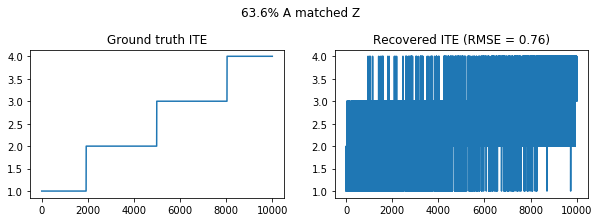

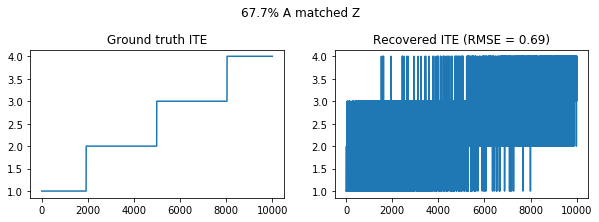

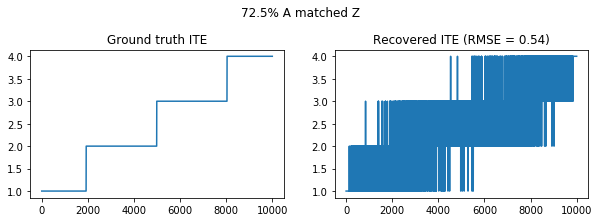

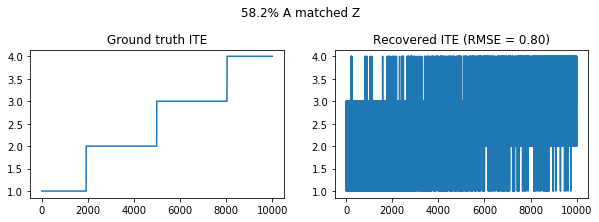

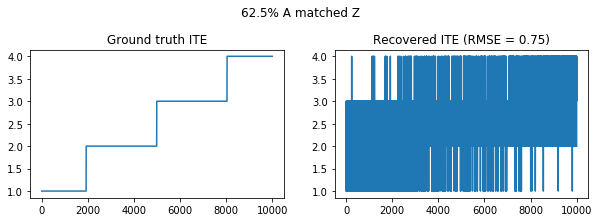

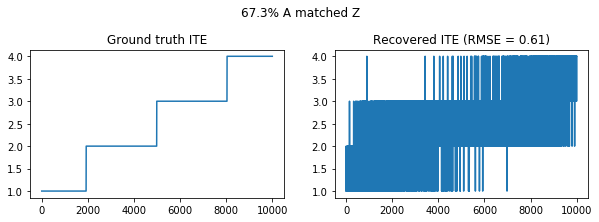

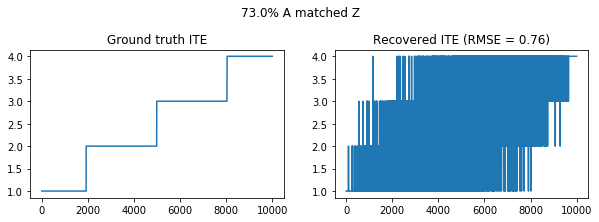

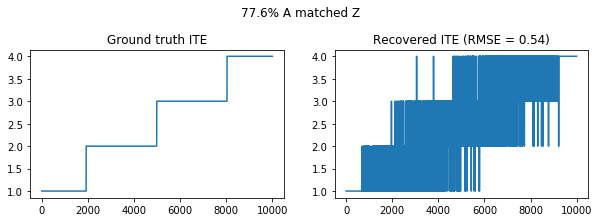

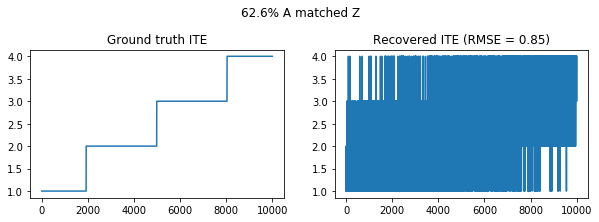

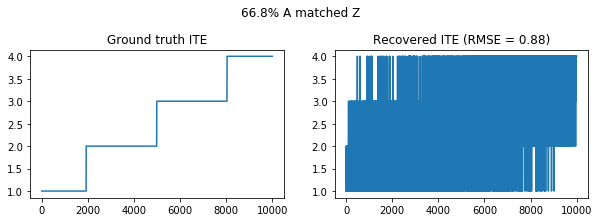

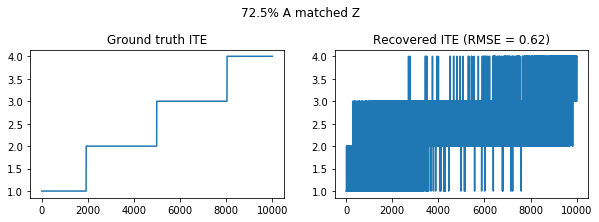

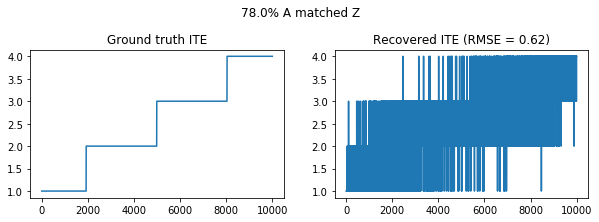

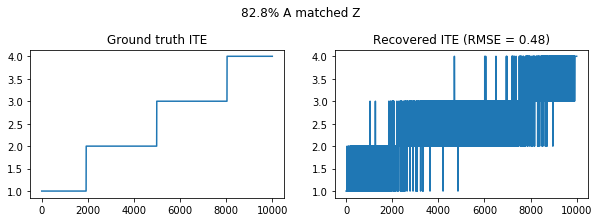

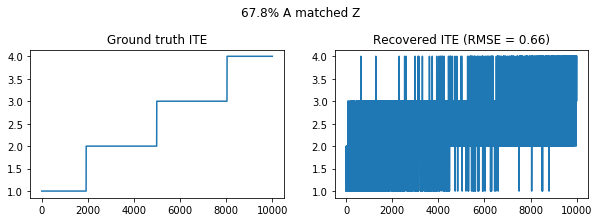

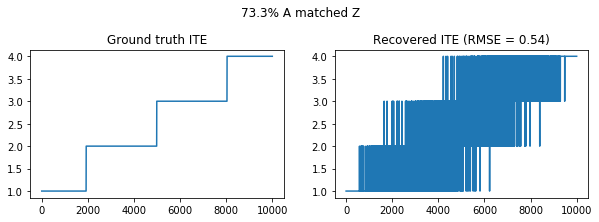

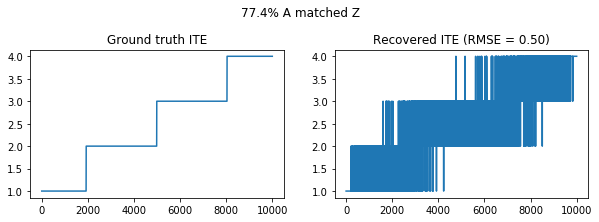

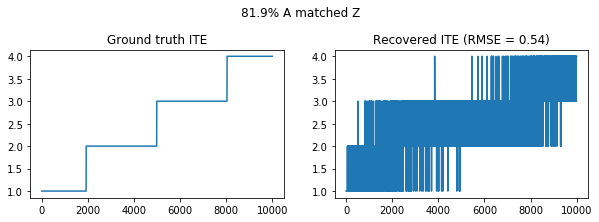

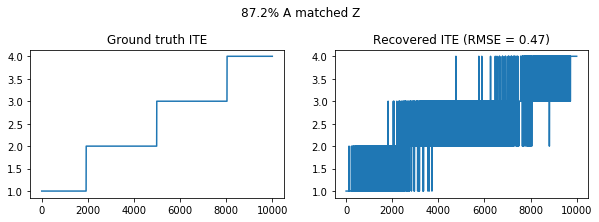

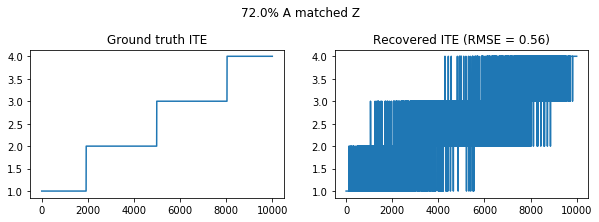

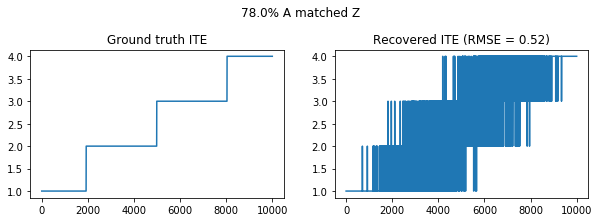

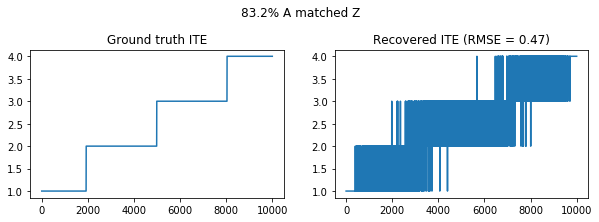

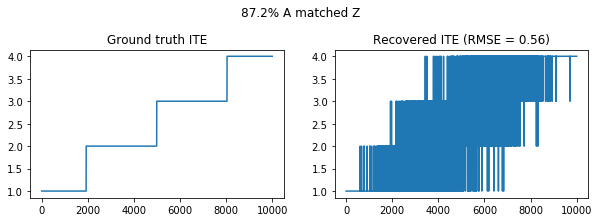

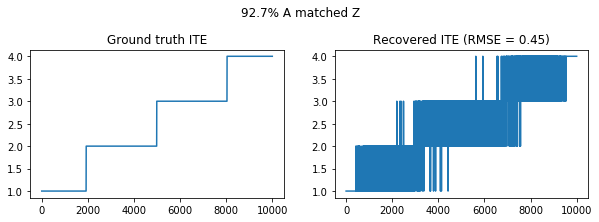

In [63]:
xDim = 50
nSim = 10000
p_AgivenZ = 0.8
p_AgivenNotZ = 0.5

A_matched_Z = []
RMSEs = []
for p_AgivenZ in [0.6, 0.7, 0.8, 0.9, 1]:
    for p_AgivenNotZ in [0.5, 0.4, 0.3, 0.2, 0.1]:

        X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        A_matched_Z.append(a_matched_z)
        RMSEs.append(rmse)

Text(0, 0.5, 'RMSE')

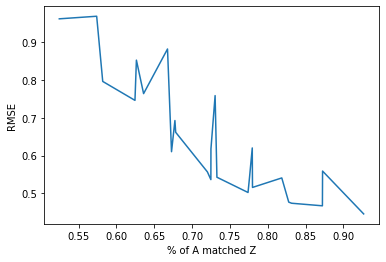

In [66]:
A_matched_Z = np.array(A_matched_Z)
RMSEs = np.array(RMSEs)
sort_indice = np.argsort(A_matched_Z)
plt.plot(A_matched_Z[sort_indice], RMSEs[sort_indice])
plt.xlabel('% of A matched Z')
plt.ylabel('RMSE')

In [51]:
def sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ):
    #** Follow the graph to generate Y
    # Y = X * beta + Z * CATE

    #** Add a U to X, A and Y
    # confounders
    x_Sigma = make_spd_matrix(xDim)
    X = np.random.multivariate_normal(np.zeros(xDim),x_Sigma,size=nSim)
    beta = np.random.choice(5, xDim, replace=True, p =[.3, .25, .2, .15, .1])

    # ground truth CATE
    CATE = np.array([1,2,3,4])
    p_G = np.exp(X[:,1])/(1+np.exp(X[:,1]))
    Group = np.zeros(nSim)
    Group[p_G < 0.75] = 1
    Group[p_G < 0.5] = 2
    Group[p_G < 0.25] = 3
    Group = Group.astype(int)

    # ground truth two-arm potential outcomes
    Y_0 = np.random.normal(np.sum(X * beta,1),1)
    #Y_1 = Y_0 + np.random.normal(CATE[Group],1)
    Y_1 = Y_0 + CATE[Group]

    # Z encourage A, and split-treatment criterion p_A_given_Z_X > p_A_given_notZ_X
    p_A_given_Z = [p_AgivenZ if x[0] > 0 else p_AgivenZ-0.1 for x in X]
    p_A_given_notZ = [p_AgivenNotZ for x in X]

#     # ground truth ITE plot
#     ite_order = np.argsort(Y_1 - Y_0)
#     plt.plot((Y_1 - Y_0)[ite_order])
#     plt.title('Ground truth ITE')

    # randomized treatment
    Z = np.random.choice(2, nSim)

    A = [np.random.choice(2, 1, p = [1-p_A_given_Z[i], p_A_given_Z[i]]) 
         if Z[i] == 1 else np.random.choice(2, 1, p = [1-p_A_given_notZ[i], p_A_given_notZ[i]])
        for i in range(nSim)]

    Y = [Y_0[i] if Z[i] == 0 else Y_1[i] for i in range(nSim)]

    Z = np.array(Z).ravel()
    A = np.array(A).ravel()
    Y = np.array(Y).ravel()
    
#     print('Z==1:',sum(Z), 'A==Z:',sum(A*Z))
    
    # return full observed data
    return X, Y, A, nSim, Group, Y_0, Y_1, Z, A

In [54]:
def fit_IPTW_LR(X_data, A_data, nObs):
    # 1. Fit propensity
    clf = LogisticRegression().fit(X_data, A_data)
    propensity = clf.predict_proba(X_data)[:,1]
    p_A = np.sum(A_data)/len(A_data)
    iptw = [p_A/propensity[i] if A_data[i] == 1 else (1-p_A)/(1-propensity[i]) for i in range(nObs)]

    print('p_A: {}, IPTW: {:.2f} +/- {:.2f}'.format(p_A, np.mean(iptw), np.std(iptw)))
    
    # 2. Fit weighted LR
    X_A_data = np.array([X_data[i] * A_data[i] for i in range(nObs)])
    model = LinearRegression(fit_intercept=False).fit(np.concatenate((X_data,X_A_data, A_data.reshape(-1,1)),1),Y_data,sample_weight=iptw)
    Yhat_0 = model.predict(np.concatenate((X_data, np.zeros(X_data.shape), np.zeros((nObs,1))),1))
    Yhat_1 = model.predict(np.concatenate((X_data,X_data, np.ones((nObs,1))),1))

    return Yhat_0, Yhat_1

In [58]:
sum(A == Z)/len(Z)

0.9272

In [61]:
def evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z):
    print('Unbiased estimated CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
        np.mean((Yhat_1 - Yhat_0)[Group_data == 0]),
               np.mean((Yhat_1 - Yhat_0)[Group_data == 1]),
                      np.mean((Yhat_1 - Yhat_0)[Group_data == 2]),
                             np.mean((Yhat_1 - Yhat_0)[Group_data == 3])))

    est_ite_order = np.argsort(Yhat_1 - Yhat_0)
    recovered_ITE = (Y_1_data - Y_0_data)[est_ite_order]

    ite_order_data = np.argsort(Y_1_data - Y_0_data)
    ground_truth_ITE = (Y_1_data - Y_0_data)[ite_order_data]

    rmse = np.sqrt(np.mean((recovered_ITE - ground_truth_ITE)**2))
    
    A_Z_matched = sum(A == Z)/len(Z)
    print('Unbiased recovered CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}.'.format(
        np.mean(recover_CATE[:sum(Group_data == 0)]), np.mean(recover_CATE[sum(Group_data == 0):sum( Group_data <= 1)]),
        np.mean(recover_CATE[sum( Group_data <= 1):sum( Group_data <= 2)]), np.mean(recover_CATE[sum( Group_data <= 2):])))
    print('{:.1f}% A matched Z, RMSE: {:.2f}'.format(A_Z_matched * 100., rmse))
    #print('Ground truth CATE:', CATE)
    
    fig = plt.figure(figsize=(10,6))

    ax1 = fig.add_subplot(2,2,1)
    ax1.plot((Y_1 - Y_0)[ite_order])
    ax1.set_title('Ground truth ITE')

    ax2 = fig.add_subplot(2,2,2)
    ax2.plot(recovered_ITE)
    ax2.set_title('Recovered ITE (RMSE = {:.2f})'.format(rmse))

    fig.suptitle('{:.1f}% A matched Z'.format(A_Z_matched * 100.))
    
    return A_Z_matched, rmse

In [ ]:
# # get biased observed data 
# obs_indices = [True if X[i,0] * X[i,2] > 0 else False for i in range(nSim)]

# X_data = X[obs_indices]
# A_data = A[obs_indices]
# Y_data = Y[obs_indices]

# # ground truth params
# Group_data = Group[obs_indices]
# Y_0_data = Y_0[obs_indices]
# Y_1_data = Y_1[obs_indices]

# nObs = sum(obs_indices)
# print('Num obs:', nObs)

In [52]:
# Fit LR
model = LinearRegression(fit_intercept=False).fit(np.concatenate((X_data,X_A_data,A_data.reshape(-1,1)),1),Y_data)
Yhat_0 = model.predict(np.concatenate((X_data,np.zeros(X_data.shape),np.zeros((nObs,1))),1))
Yhat_1 = model.predict(np.concatenate((X_data,X_data,np.ones((nObs,1))),1))

print('Biased est. CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean((Yhat_1 - Yhat_0)[Group_data == 0]),
           np.mean((Yhat_1 - Yhat_0)[Group_data == 1]),
                  np.mean((Yhat_1 - Yhat_0)[Group_data == 2]),
                         np.mean((Yhat_1 - Yhat_0)[Group_data == 3])))

indices_sort = np.argsort(Yhat_1 - Yhat_0)
recover_CATE = (Y_1_data - Y_0_data)[indices_sort]
print('Biased rec. CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(recover_CATE[:sum(Group_data == 0)]), np.mean(recover_CATE[sum(Group_data == 0):sum( Group_data <= 1)]),
    np.mean(recover_CATE[sum( Group_data <= 1):sum( Group_data <= 2)]), np.mean(recover_CATE[sum( Group_data <= 2):])))
print('Ground truth CATE:', CATE)

Biased est. CATE: 1.01, 1.38, 1.66, 1.98
Biased rec. CATE: 1.47, 2.17, 2.83, 3.56
Ground truth CATE: [1 2 3 4]
